# Gender and ethnicity authentificator
# Dataset:
We used free open UTK-dataset that was uploaded in the internet.
# https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv/data
Dataset we use have: Age, ethnicity, gender, image_name and img_pixels as a pixel parameter of a photo. We decided that we will only train model to find gender and ethnicity because due to the low quality of photo, that will be impossible to get good accuracy on that parameter.
We imported this dataset to the GDrive and then to colab.


# Link to Google Drive:
# https://drive.google.com/drive/folders/1dO2G-VW-6YBIjUEYtyWsF6DB0a-8-LRf?usp=share_link

---

Prepared by: Toleugazy Daulet, Mukhambetaliyev Aslanbek and Zainurainov Ramazam.

---

IT-2204 group.

---


Project manager: Sultanmurat Yeleu



In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from google.colab import drive

drive.mount('/content/drive')

data_path = '/content/drive/My Drive/Final dataset/age_gender.csv'
data = pd.read_csv(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Image Data Shape: (23705, 48, 48, 1)


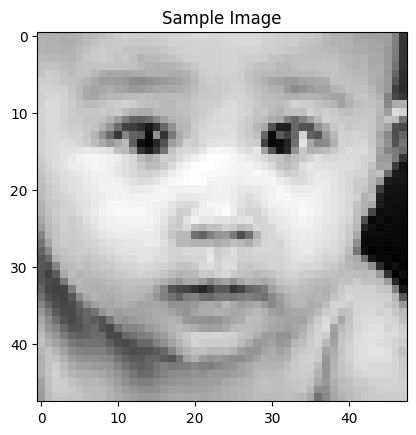

In [4]:
if isinstance(data['pixels'].iloc[0], str):
    data['pixels'] = data['pixels'].apply(lambda x: np.array(x.split(), dtype="float32"))
else:
    print("'pixels' column is already in the correct format.")

X = np.stack(data['pixels'].values)
X = X.reshape(-1, 48, 48, 1)
X /= 255.0  # Normalize pixel values

print(f"Image Data Shape: {X.shape}")

# Display a sample image
import matplotlib.pyplot as plt
plt.imshow(X[0].reshape(48, 48), cmap='gray')
plt.title('Sample Image')
plt.show()


In [5]:
# Prepare labels
y_gender = to_categorical(data['gender'].values)
y_ethnicity = to_categorical(data['ethnicity'].values)
print(f"Gender Labels Shape: {y_gender.shape}")
print(f"Ethnicity Labels Shape: {y_ethnicity.shape}")

Gender Labels Shape: (23705, 2)
Ethnicity Labels Shape: (23705, 5)


In [6]:
# Split the dataset
X_train, X_test, y_gender_train, y_gender_test, y_ethnicity_train, y_ethnicity_test = train_test_split(
    X, y_gender, y_ethnicity, test_size=0.2, random_state=42
)
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (18964, 48, 48, 1)
Testing Data Shape: (4741, 48, 48, 1)


In [7]:
# Define the model
input_layer = Input(shape=(48, 48, 1))
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
gender_output = Dense(2, activation='softmax', name='gender_output')(x)
ethnicity_output = Dense(y_ethnicity.shape[1], activation='softmax', name='ethnicity_output')(x)

model = Model(inputs=input_layer, outputs=[gender_output, ethnicity_output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 46, 46, 32)           320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 21, 21, 64)           18496     ['max_pooling2d[0][0]']   

In [8]:
model.compile(optimizer='adam',
              loss={'gender_output': 'categorical_crossentropy', 'ethnicity_output': 'categorical_crossentropy'},
              metrics=['accuracy'])

Epoch 1/40
297/297 [==============================] - 56s 181ms/step - loss: 1.6897 - gender_output_loss: 0.4990 - ethnicity_output_loss: 1.1906 - gender_output_accuracy: 0.7535 - ethnicity_output_accuracy: 0.5475 - val_loss: 1.3487 - val_gender_output_loss: 0.3817 - val_ethnicity_output_loss: 0.9670 - val_gender_output_accuracy: 0.8306 - val_ethnicity_output_accuracy: 0.6718
Epoch 2/40
297/297 [==============================] - 55s 184ms/step - loss: 1.3529 - gender_output_loss: 0.3865 - ethnicity_output_loss: 0.9664 - gender_output_accuracy: 0.8222 - ethnicity_output_accuracy: 0.6492 - val_loss: 1.1645 - val_gender_output_loss: 0.3234 - val_ethnicity_output_loss: 0.8411 - val_gender_output_accuracy: 0.8574 - val_ethnicity_output_accuracy: 0.7127
Epoch 3/40
297/297 [==============================] - 58s 195ms/step - loss: 1.2288 - gender_output_loss: 0.3499 - ethnicity_output_loss: 0.8789 - gender_output_accuracy: 0.8410 - ethnicity_output_accuracy: 0.6942 - val_loss: 1.0969 - val_gen

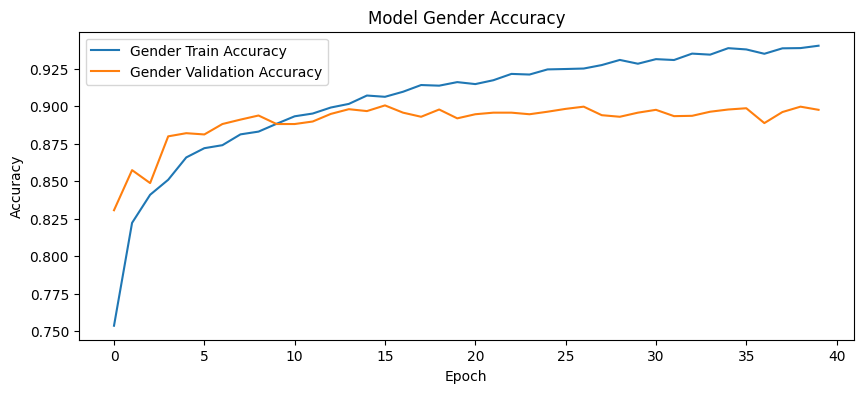

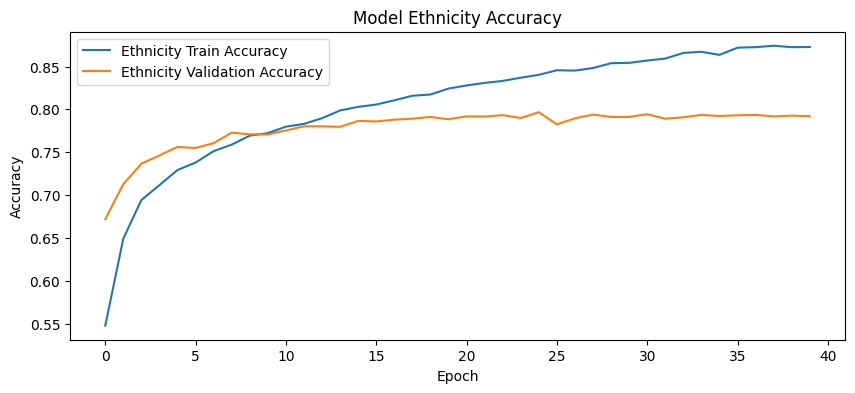

In [9]:
from keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(),
              loss={'gender_output': 'categorical_crossentropy', 'ethnicity_output': 'categorical_crossentropy'},
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, {'gender_output': y_gender_train, 'ethnicity_output': y_ethnicity_train},
                    validation_data=(X_test, {'gender_output': y_gender_test, 'ethnicity_output': y_ethnicity_test}),
                    epochs=40, batch_size=64)



import matplotlib.pyplot as plt

# For Gender Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['gender_output_accuracy'], label='Gender Train Accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='Gender Validation Accuracy')
plt.title('Model Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# For Ethnicity Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['ethnicity_output_accuracy'], label='Ethnicity Train Accuracy')
plt.plot(history.history['val_ethnicity_output_accuracy'], label='Ethnicity Validation Accuracy')
plt.title('Model Ethnicity Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [16]:
model_path = '/content/new_model.h5'
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
!pip install tensorflowjs

In [17]:
!tensorflowjs_converter \
    --input_format=keras \
    new_model.h5 \
    my_tfjs_model

2024-03-06 11:17:51.145330: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 11:17:51.145399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 11:17:51.147048: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 11:17:52.490294: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
